#### Ce notebook rassemble les méthodes statistiques employées pour la sélection de variables pour le modèle de régression mogistique ordinale

In [34]:
!pip install tqdm

### Importation des modules essentiels

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mplcyberpunk
plt.style.use('cyberpunk')

from mord import LogisticAT     # mord (Multi-class Ordinal Regression) est le module python adéquat pour la régression logistique ordinale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from typing import Tuple, Dict, List, Callable, Any

np.random.seed(42) # set random seed for reproductibility
from tqdm import tqdm

## 1 Lecture des données

In [36]:
df_nutriscore = pd.read_csv("data\data_clean_principal.csv".replace('\\', '/'))
df_nutriscore.head()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,...,countries_fr,ingredients_text,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr
0,586.0,3.800000,1.4,NaN,NaN,16.200000,0.5,1.5,9.3,0.60,...,France,NaN,400 g,NaN,NaN,NaN,NaN,NaN,NaN,a
1,1665.0,2.700000,0.6,NaN,NaN,12.766667,3.3,4.6,12.0,1.11,...,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a
2,452.0,1.600000,0.9,NaN,NaN,9.333333,1.3,0.8,4.3,0.45,...,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a
3,155.0,0.500000,0.1,NaN,NaN,5.900000,5.5,3.0,0.7,0.25,...,France,"i sont full'/ s, . tt to it values kcal \fatiò...",NaN,1.0,[ i-sont-full-s -> fr:i-sont-full-s ] [ i-s...,en:e400,E400 - Acide alginique,0.0,0.0,a
4,586.0,0.366667,1.0,NaN,NaN,5.800000,6.0,3.0,5.0,0.09,...,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a


In [37]:
df_nutriscore.isnull().sum()

energy_100g                                    0
fat_100g                                       0
saturated-fat_100g                             0
trans-fat_100g                               173
cholesterol_100g                              93
carbohydrates_100g                             0
sugars_100g                                    0
fiber_100g                                     0
proteins_100g                                  0
salt_100g                                      0
sodium_100g                                    0
vitamin-a_100g                                93
vitamin-c_100g                                17
calcium_100g                                  93
iron_100g                                     73
nutrition-score-fr_100g                        0
code                                           0
creator                                        0
created_t                                      0
last_modified_t                                0
product_name        

In [38]:
df_nutriscore.dropna(inplace=True)

In [39]:
df_nutriscore.isnull().sum()

energy_100g                                0
fat_100g                                   0
saturated-fat_100g                         0
trans-fat_100g                             0
cholesterol_100g                           0
carbohydrates_100g                         0
sugars_100g                                0
fiber_100g                                 0
proteins_100g                              0
salt_100g                                  0
sodium_100g                                0
vitamin-a_100g                             0
vitamin-c_100g                             0
calcium_100g                               0
iron_100g                                  0
nutrition-score-fr_100g                    0
code                                       0
creator                                    0
created_t                                  0
last_modified_t                            0
product_name                               0
brands                                     0
countries 

<AxesSubplot:xlabel='nutrition_grade_fr', ylabel='count'>

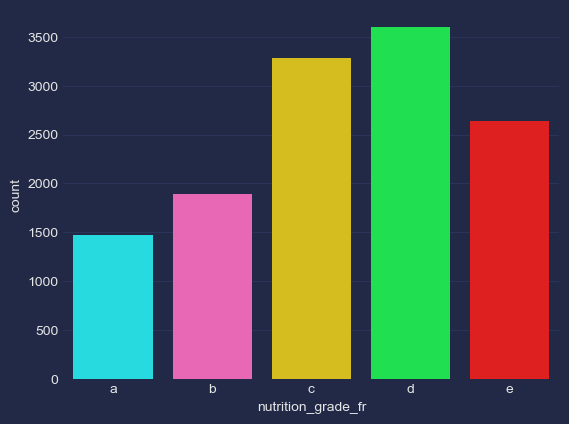

In [40]:
sns.countplot(df_nutriscore, x='nutrition_grade_fr')

Les données sont sur-représentées pour certaines classes, ce qui pourrait causer du biais dans le modèle.

## Equilibrage des données

In [41]:
# On compte le nombre d'observation par classe
counts = df_nutriscore['nutrition_grade_fr'].value_counts()
# on récupère le min
min_samples = counts.min()

# on crée un nouveau dataframe pour contenir les données équilibrées
df_nutriscore_eq = pd.DataFrame()
# on fait uun rééchantillonage en fixant le nombre d'observations par classe au min calculé précédemment
for label in counts.index:
    subset = df_nutriscore[df_nutriscore['nutrition_grade_fr'] == label].sample(min_samples, random_state=42) # chaque échantillon est tiré aléatoirement et de manière reproductible avec le random seed
    df_nutriscore_eq = pd.concat([df_nutriscore_eq, subset], axis=0) # on joint les données en lignes


<AxesSubplot:xlabel='nutrition_grade_fr', ylabel='count'>

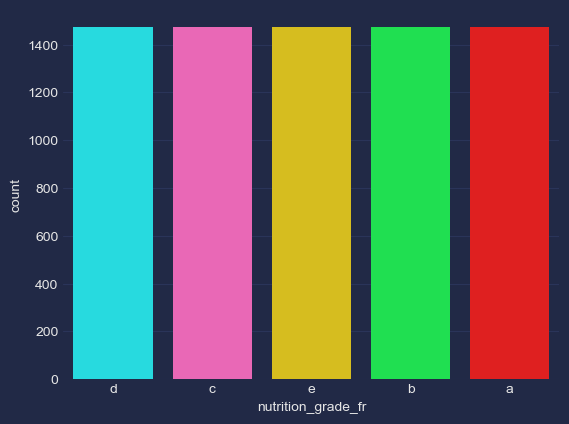

In [42]:
sns.countplot(df_nutriscore_eq, x='nutrition_grade_fr')

### Numérisation de la variable qualitative

In [43]:
# On récupère toutes les colonnes ne contenant que des valeurs numériques pour servir de variables explicatives
liste_variables_quantitatives = df_nutriscore_eq.select_dtypes(include=['number']).columns.tolist()

# notre dataframe final contient les variables quantitatives et la variable d'intérêt "nutrition_grade_fr"
df_nutriscore_numeric = df_nutriscore_eq[liste_variables_quantitatives + ["nutrition_grade_fr"]]

# Transformation de la variable quantitative en quanti codés de 0 à 4 selon le classement
nutri_code = {"e": 0, "d":1, "c":2, "b":3, "a":4}
df_nutriscore_numeric["nutrition_grade_fr"] = df_nutriscore_numeric["nutrition_grade_fr"].apply(lambda x: nutri_code[x])

C:\Users\jaure\AppData\Local\Temp\ipykernel_5124\4267136583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nutriscore_numeric["nutrition_grade_fr"] = df_nutriscore_numeric["nutrition_grade_fr"].apply(lambda x: nutri_code[x])


In [44]:
def split_data(data, variable_interet = "nutrition_grade_fr", train_size = 0.8):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    """Cette fonction permet de séparer des jeu de données en une matrice contenant les variables explicatives et un vecteur contenant la variable d'intérêt. Elle renvoie 
    un tuple contenant les variables citées précedemment pour la phase d'entrainement et la phase de test.

    Args:
        data (dataframe): jeu de données complet
        variable_interet (str, optional): nom de la variable explicative dans le jeu de données. Par défaut "nutrition_grade_fr".
        train_size (float, optional): ratio de données utilisé pour la phase d'entrainement. Par défaut 0.8 <=> 80% des données pour l'entrainement

    Returns:
        tuple: variables explicatives et d'intéret pour les phase d'entrainement et de test
    """
    X = data.drop(labels=[variable_interet], axis=1).values
    
    # Normalisation des données
    X = scaler.fit_transform(X)

    y = data[variable_interet].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df_nutriscore_numeric)

# Méthodes de sélection de variables

## 1 Sélection univariée par test de Chi2

In [45]:

def chi2_selector(list_k : List, model = LogisticAT(), X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """Cette fonction permet une séléction de variables en se basant sur les performances obtenues en fonction du test du chi_2

    Args:
        list_k (List): liste des variables explicatives passées au modèle
        model : Notre modèle de régression. Par défaut LogisticAT().
        X_train (optional): Matrice des variables explicatives pour l'entrainement. Par défaut X_train.
        X_test (optional): Matrice des variables explicatives pour le test. Par défaut X_test.
        y_train (_type_, optional): Labels de classe pour l'entrainement. Par défaut y_train.
        y_test (_type_, optional): Labels de classe pour le test. Par défaut y_test.

    Returns:
        Dict: Dictionnaire repertoriant les valeurs de k et la liste des variables passées au modèle
    """
    from sklearn.feature_selection import SelectKBest, chi2
    
    results = {}
    for k in list_k:
    # Sélection des k meilleures caractéristiques en utilisant le test du Chi-deux
        print(f"Pour k = {k}")
        print("***********************")
        selector = SelectKBest(chi2, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        
        indices_selectionnes = selector.get_support(indices=True)

        # Entraînement du modèle sur les caractéristiques sélectionnées
        model.fit(X_train_selected, y_train)

        # prédictions sur l'ensemble de test
        predictions = model.predict(X_test_selected)
        # Mesure la performance du modèle
        accuracy = accuracy_score(y_test, predictions)
        # on peut également récupérer les p_values au besoin avec "selector.pvalues_"
        
        # on récupère les noms de colonnes séléctionnées par itération
        results[f"k = {k}"] = f"variables sélectionnées {list(df_nutriscore_numeric.columns[indices_selectionnes])}"
        
        # Affichage du résultat de l'itération
        print("Précision du modèle sur l'ensemble test : {:.2f}%".format(accuracy * 100))
        print("")
    return results


In [46]:
resultats = chi2_selector(list_k=np.arange(1, len(df_nutriscore_numeric.columns.tolist())))

Pour k = 1
***********************
Précision du modèle sur l'ensemble test : 11.13%

Pour k = 2
***********************
Précision du modèle sur l'ensemble test : 51.12%

Pour k = 3
***********************
Précision du modèle sur l'ensemble test : 59.40%

Pour k = 4
***********************
Précision du modèle sur l'ensemble test : 59.95%

Pour k = 5
***********************
Précision du modèle sur l'ensemble test : 60.83%

Pour k = 6
***********************
Précision du modèle sur l'ensemble test : 94.70%

Pour k = 7
***********************
Précision du modèle sur l'ensemble test : 94.70%

Pour k = 8
***********************
Précision du modèle sur l'ensemble test : 95.38%

Pour k = 9
***********************
Précision du modèle sur l'ensemble test : 95.38%

Pour k = 10
***********************
Précision du modèle sur l'ensemble test : 95.45%

Pour k = 11
***********************
Précision du modèle sur l'ensemble test : 95.45%

Pour k = 12
***********************
Précision du modèle sur l'e

Selon le chi2, le meilleur modèle est celui avec les variables :

In [47]:
resultats["k = 7"]

"variables sélectionnées ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'sugars_100g', 'nutrition-score-fr_100g']"

## Sélection par critère AIC | BIC

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np

def calcul_bic_aic(model, X, y, penalty_term, criterion='bic'):
    # Calcul de la log-vraisemblance
    log_likelihood = -log_loss(y, model.predict_proba(X))
    # Obtenez le nombre de paramètres du modèle
    num_params = len(model.coef_.ravel()) + 1  # coef_ contient les coefficients du modèle
    # Calcul du BIC ou l'AIC
    if criterion == 'bic':
        bic_aic = -2 * log_likelihood + penalty_term * np.log(X.shape[0]) * num_params
    elif criterion == 'aic':
        bic_aic = -2 * log_likelihood + penalty_term * 2 * num_params
    else:
        raise ValueError("Le critère doit être 'bic' ou 'aic'.")
    return bic_aic

def compare_model(liste_variables : List, model):
    
    X_train, X_test, y_train, y_test = train_test_split(df_nutriscore_numeric[liste_variables], df_nutriscore_numeric['nutrition_grade_fr'].values, test_size=0.8, random_state=42)

    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Cterme de pénalité (à ajuster en fonction des besoins)
    penalty_term = 1.0

    # Calcule le BIC ou l'AIC pour le modèle
    bic_aic = calcul_bic_aic(model, X_train, y_train, penalty_term, criterion='bic')

    return bic_aic


In [49]:
results = {}
for l in tqdm([list(df_nutriscore_numeric.columns[:i]) for i in range(3, len(df_nutriscore_numeric.columns.to_list()) -1)]):
    results[f" variables {l} "] = f" BIC = {compare_model(liste_variables=l, model=LogisticAT())}"

100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


In [50]:
results

{" variables ['energy_100g', 'fat_100g', 'saturated-fat_100g'] ": ' BIC = 31.275638137061133',
 " variables ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g'] ": ' BIC = 38.496365569545766',
 " variables ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g'] ": ' BIC = 45.750414365166804',
 " variables ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g'] ": ' BIC = 53.043890461302986',
 " variables ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g'] ": ' BIC = 60.2732854090703',
 " variables ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g'] ": ' BIC = 67.39356145030322',
 " variables ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', '

#### Il n'existe pas de module python pour comparer le BIC ou AIC, j'ai du reprendre la formule à la main. C'est à revoir avec le reste de l'équipe ou le data scientist

## 3 Rétroélimination (Backward Elimination) : 
On commence par inclure toutes les variables, puis on supprime itérativement les variables non significatives en fonction de la p-value.

In [ ]:
X_train, X_test, y_train, y_test = split_data(df_nutriscore_numeric)

model = LogisticAT()

# Entraînement du modèle
model.fit(X_train, y_train)

# Méthode pour évaluer la performance du modèle
def precision(model, X, y):
    y_pred = model.predict(X)

    return accuracy_score(y, y_pred)

# Évaluation de la performance du modèle sur l'ensemble de test en prenant toutes le variables explicatives
accuracy = precision(model, X_test, y_test)
print("Accuracy :{:.2f}%".format(accuracy * 100))


Accuracy :94.77%


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from mord import LogisticAT
from sklearn.metrics import accuracy_score

# Supposons que vos données soient dans un DataFrame appelé `data`
X_train = df_nutriscore_numeric.drop('nutrition_grade_fr', axis=1)
y_train = df_nutriscore_numeric['nutrition_grade_fr']

def backward_elimination(X, y, model, significance_level=0.05):
    num_vars = len(list(X.columns))
    selected_features = list(X.columns)
    for i in tqdm(range(num_vars)):
        p_values = []
        for feature in selected_features:
            features_subset = selected_features.copy()
            features_subset.remove(feature)
            model.fit(X[features_subset], y)
            y_pred = model.predict(X[features_subset])
            p_value = 1 - accuracy_score(y, y_pred)  # Utilisez l'erreur de classification comme critère
            p_values.append(p_value)
        max_p_value = max(p_values)
        if max_p_value > significance_level:
            removed_feature = selected_features[p_values.index(max_p_value)]
            selected_features.remove(removed_feature)
        else:
            break
    return X[selected_features]

# Initialisation du modèle
model = LogisticAT()

# Appel de la fonction de sélection des variables
variables_selectionnees = backward_elimination(X_train, y_train, model)

print("Variables sélectionnées :", variables_selectionnees.columns.to_list())


Le code est à revoir encore quelques bugs de type de données que je dois corriger encore...!

## 4 Sélection avant (Forward Selection) : 
On commence avec un modèle une seule variable et on ajoutez itérativement des variables jusqu'à ce qu'elles deviennent significatives.